# Simulation of Protein-Peptide Datasets for Benchmarking Aggregatin and Imputation Methods 

Simulating datasets mimicing protein and peptide abundances of MS experiments for benchmarking purposes is one 
feature of PyProteoNet. Therefore, PyProteoNet provides a bunch of function to randomly draw and caluculate abundance values, simulate
several different errors and introduce missing values.

The following shows an example which starting from a MoleculeSet samples abundance values for proteins, computes peptide abundances
from those protein abundances and applies several random error which can also be observed in real-world datasets. Finally several missing values
are introduced to the dataset such that it can be used as a benchmark for protein imputation methods.

The below picture gives an overview of the data simulation pipeline.

![title](img/sim_pipeline.png)

We start of with a `MoleculeSet`. For creating real benchmarking datasets it might be useful to use a `MoleculeSet` from a
real-world dataset, however, here we use a small toy example.

In [1]:
import pandas as pd
from pyproteonet.data import MoleculeSet

proteins = pd.DataFrame(index=range(10))
peptides = pd.DataFrame(index=range(100))
mapping = pd.DataFrame({'peptide':peptides.index, 'protein':peptides.index % 10})
mapping.set_index(['peptide', 'protein'], inplace=True)

ms = MoleculeSet(molecules = {'protein':proteins, 'peptide':peptides},
                 mappings = {'peptide-protein': mapping}
                )

Alternatively, we can create a molecule set from a node degree distribution. Here we create 2 proteins with degree 0, 5 proteins with degree 1, 7 proteins
with degree 2 and 7 proteins with degree 7. 1 Peptide has degree 0, 20 peptides degree 1, and 10 peptides are shared (degree 2).

In [2]:
from pyproteonet.simulation.molecule_set import molecule_set_from_degree_distribution

ms2 = molecule_set_from_degree_distribution(molecule1_degree_distribution= [2, 5, 7, 7], molecule1_name='protein',
                                            molecule2_degree_distribution = [1, 20, 10], molecule2_name='peptide')

We start off creating a `Dataset` with protein abundances drawn from a normal distribution in log space
(usually the logarithm of protein and peptide abundances of real world datasets roughly follows a normal distribution).
We also apply a small error term (as well in log space).

In [3]:
from pyproteonet.simulation import draw_normal_log_space
dataset = draw_normal_log_space(
            molecule_set=ms,
            log_mu=10,
            log_sigma=5,
            samples=10,
            molecule='protein',
            column='abundance',
            log_error_mu = 0,
            log_error_sigma = 1,
          )

Optionally, we might introduce a condition for some of the samples and proteins by multiplying the protein abundance in some samples with a power of two. This can be done as follows:

In [4]:
from pyproteonet.simulation import introduce_random_condition

In [5]:
dataset = introduce_random_condition(dataset=dataset, molecule='protein', column='abundance', 
                                     affected=0.3, log2_cond_factor_mean=2, log2_cond_factor_std=1,
                                     samples=[f'sample{i}' for i in range(5)])

Given the protein abundance we can compute peptide abunces using the mapping from peptides to proteins.
Every peptide occurs in a set of proteins, so the theoretical peptide abundance should be the sum of protein abundances it occurs in.

In [6]:
from pyproteonet.aggregation import partner_aggregation

_ = partner_aggregation(
    dataset = dataset,
    molecule="peptide",
    partner_column="abundance",
    mapping="peptide-protein",
    result_column="abundance",
    only_unique=False,
)

In real-world datasets it can be observed that some peptides are easier to detect than other. To simulate this we multiply
every peptide abundance with a scaling factor drawn once for every peptide.

In [7]:
from pyproteonet.simulation import per_molecule_random_scaling
dataset = per_molecule_random_scaling(dataset=dataset,
                                      beta_distr_alpha=2.5,
                                      beta_distr_beta=5,
                                      molecule='peptide',
                                      column='abundance',
                                     )

Finally, we simulate some peptide error (a background measurement noise as well as the counting nature of an MS experiment)
to make the resulting peptide abundances more realistic.

In [8]:
from pyproteonet.simulation import add_positive_gaussian, poisson_error
dataset = add_positive_gaussian(dataset,
                                molecule='peptide',
                                column='abundance',
                                sigma=0,
                                mu=5000,
                               )
dataset = poisson_error(dataset=dataset, molecule='peptide', column='abundance')

For simulation of a protein-peptide dataset as described above, there also is a convenience function summarizing all the steps which might be used as an alternative to calling each step individually.

In [9]:
from pyproteonet.simulation import simulate_protein_peptide_dataset
dataset2 = simulate_protein_peptide_dataset(molecule_set=ms, mapping='peptide-protein', protein_molecule='protein', peptide_molecule='peptide',
                                            log_abundance_mu=10, log_abundance_sigma=5, log_protein_error_sigma=0.3,
                                            flyability_alpha=2.5, flyability_beta=5, peptide_noise_mu=5000, peptide_noise_sigma=0,
                                            log2_condition_means=[2], log2_condition_stds=[1], condition_affected=[0.3],
                                            condition_samples=[f'sample{i}' for i in range(5)])

Last but not least we can simulate some missing values.
While MNARs are more likely to occur for low abundant values, MCARs are sampled completly at random across all molecules.

In [10]:
from pyproteonet.simulation import simulate_mnars_thresholding, simulate_mcars
dataset = simulate_mnars_thresholding(dataset, thresh_mu=7000, thresh_sigma=4000, molecule='peptide', column='abundance')
dataset = simulate_mcars(dataset, amount=0.2, molecule='peptide', column='abundance')

Thats it, we have created an in silico dataset. Lets plot its histogram across all samples!

Sidenote:
Instead of calling all those functions one by one, there also is a higher level
function called `simulate_protein_peptide_dataset(...)` in the simulation module.

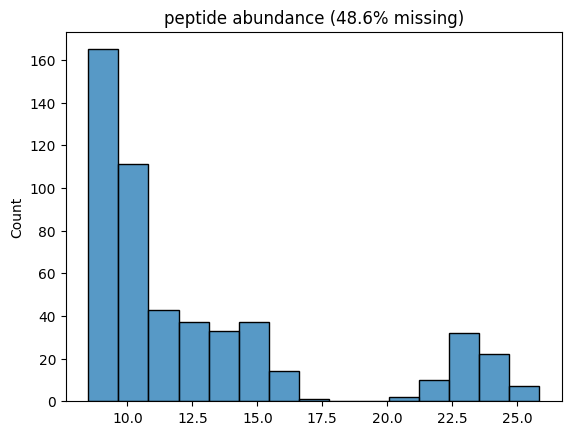

In [11]:
from pyproteonet.visualization import plot_hist
plot_hist(dataset, molecule='peptide', column='abundance', log_space=True)